In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121  # Changed from VGG19 to DenseNet121
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import (classification_report, confusion_matrix, 
                           precision_score, recall_score, f1_score, 
                           accuracy_score)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from collections import Counter

# ====== CONFIGURATION ======
class Config:
    BATCH_SIZE = 8
    IMG_SIZE = (256, 256)  # DenseNet typically uses 224x224, but we'll keep your size
    NUM_FOLDS = 5
    EPOCHS = 50
    LEARNING_RATE = 3e-5
    DROPOUT_RATE = 0.5
    SE_RATIO = 16
    BASE_DIR = '/kaggle/input/local-preprocessed-dataset/LOCAL PREPROCESSED DATASET'
    SEED = 42
    MIN_SAMPLES = 20

# ====== DATA AUGMENTATION ======
def create_augmenter():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.95, 1.05],
        fill_mode='reflect',
        validation_split=0.2
    )

# ====== SQUEEZE-EXCITATION BLOCK ======
def se_block(input_tensor, ratio=Config.SE_RATIO):
    channels = input_tensor.shape[-1]
    se_shape = (1, 1, channels)
    
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(channels // ratio, activation='relu', 
                     kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(channels, activation='sigmoid', 
                     kernel_initializer='he_normal', use_bias=False)(se)
    
    return layers.Multiply()([input_tensor, se])

# ====== ENHANCED DENSENET MODEL ======
def build_enhanced_densenet(num_classes):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(*Config.IMG_SIZE, 3)
    )
    
    # Freeze all convolutional layers
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(Config.DROPOUT_RATE)(x)
    x = layers.Dense(256, activation='relu', 
                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(Config.DROPOUT_RATE)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    optimizer = optimizers.Adam(
        learning_rate=Config.LEARNING_RATE,
        clipnorm=1.0
    )
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# ====== CUSTOM DATA GENERATOR ======
class AdvancedDataGenerator(Sequence):
    def __init__(self, filepaths, labels, datagen, batch_size=32, img_size=(256,256), shuffle=True):
        self.filepaths = filepaths
        self.labels = labels
        self.datagen = datagen
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.filepaths) / self.batch_size)

    def __getitem__(self, index):
        batch_files = self.filepaths[index*self.batch_size:(index+1)*self.batch_size]
        batch_labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        images = []
        for filepath in batch_files:
            img = image.load_img(filepath, target_size=self.img_size)
            img_array = image.img_to_array(img)
            img_array = self.datagen.standardize(img_array)
            images.append(img_array)
            
        return np.array(images), tf.keras.utils.to_categorical(batch_labels, num_classes=len(set(self.labels)))

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.filepaths))
            np.random.shuffle(indices)
            self.filepaths = [self.filepaths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]

# ====== TRAINING PIPELINE ======
def run_training():
    # Initialize data
    datagen = create_augmenter()
    train_gen = datagen.flow_from_directory(
        Config.BASE_DIR,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=Config.SEED
    )
    
    # Data integrity checks
    print("\n=== DATA VALIDATION ===")
    print("Class distribution in training:", Counter(train_gen.labels))
    
    val_gen = datagen.flow_from_directory(
        Config.BASE_DIR,
        target_size=Config.IMG_SIZE,
        batch_size=Config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=Config.SEED
    )
    print("Class distribution in validation:", Counter(val_gen.labels))
    
    # Verify no overlap
    train_files = set(train_gen.filepaths)
    val_files = set(val_gen.filepaths)
    print(f"Number of overlapping files: {len(train_files & val_files)}")
    
    class_indices = train_gen.class_indices
    X = train_gen.filepaths
    y = train_gen.labels
    
    # Cross-validation setup
    kf = KFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=Config.SEED)
    fold_no = 1
    history_list = []
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }

    for train_idx, val_idx in kf.split(X, y):
        print(f"\n🔵 Fold {fold_no}")
        
        # Create generators
        simple_datagen = ImageDataGenerator(rescale=1./255)
        train_data = AdvancedDataGenerator(
            [X[i] for i in train_idx],
            [y[i] for i in train_idx],
            simple_datagen,
            Config.BATCH_SIZE,
            Config.IMG_SIZE
        )
        val_data = AdvancedDataGenerator(
            [X[i] for i in val_idx],
            [y[i] for i in val_idx],
            simple_datagen,
            Config.BATCH_SIZE,
            Config.IMG_SIZE,
            shuffle=False
        )
        
        # Build model - changed to DenseNet
        model = build_enhanced_densenet(len(class_indices))
        
        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_auc',
                patience=15,
                mode='max',
                baseline=0.85,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=8,
                min_lr=1e-6,
                cooldown=2
            ),
            callbacks.ModelCheckpoint(
                f'densenet_fold_{fold_no}.keras',  # Changed filename to densenet
                monitor='val_auc',
                save_best_only=True,
                mode='max'
            )
        ]
        
        # Train
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=Config.EPOCHS,
            callbacks=callbacks_list,
            verbose=1
        )
        history_list.append(history)
        
        # Evaluate
        val_preds = model.predict(val_data, verbose=0)
        val_preds_labels = np.argmax(val_preds, axis=1)
        val_true_labels = val_data.labels
        
        # Store metrics
        metrics['accuracy'].append(accuracy_score(val_true_labels, val_preds_labels))
        metrics['precision'].append(precision_score(val_true_labels, val_preds_labels, average='weighted'))
        metrics['recall'].append(recall_score(val_true_labels, val_preds_labels, average='weighted'))
        metrics['f1'].append(f1_score(val_true_labels, val_preds_labels, average='weighted'))
        metrics['auc'].append(np.mean(history.history['val_auc'][-5:]))
        
        print(f"✅ Fold {fold_no} Results:")
        print(f"Accuracy: {metrics['accuracy'][-1]*100:.2f}%")
        print(f"AUC: {metrics['auc'][-1]:.4f}")
        
        fold_no += 1
        tf.keras.backend.clear_session()
        gc.collect()
    
    # Final results
    print("\n=== CROSS-VALIDATION RESULTS ===")
    for metric, values in metrics.items():
        print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    
    return history_list, metrics, class_indices, X, y

# ====== VISUALIZATION ======
def plot_results(history_list, metrics, class_indices, X, y):
    # Training curves
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    for i, history in enumerate(history_list):
        plt.plot(history.history['accuracy'], linestyle='--', alpha=0.3, color='blue')
        plt.plot(history.history['val_accuracy'], alpha=0.3, color='orange')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    for i, history in enumerate(history_list):
        plt.plot(history.history['loss'], linestyle='--', alpha=0.3, color='blue')
        plt.plot(history.history['val_loss'], alpha=0.3, color='orange')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Confusion matrix for best fold
    best_fold = np.argmax(metrics['auc']) + 1
    model = tf.keras.models.load_model(f'densenet_fold_{best_fold}.keras')  # Changed to densenet
    
    # Get validation data for best fold
    kf = KFold(n_splits=Config.NUM_FOLDS, shuffle=True, random_state=Config.SEED)
    splits = list(kf.split(X, y))
    _, val_idx = splits[best_fold-1]
    
    val_data = AdvancedDataGenerator(
        [X[i] for i in val_idx],
        [y[i] for i in val_idx],
        ImageDataGenerator(rescale=1./255),
        Config.BATCH_SIZE,
        Config.IMG_SIZE,
        shuffle=False
    )
    
    val_preds = model.predict(val_data)
    val_preds_labels = np.argmax(val_preds, axis=1)
    
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(val_data.labels, val_preds_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_indices.keys(),
                yticklabels=class_indices.keys())
    plt.title(f'DenseNet Confusion Matrix (Fold {best_fold})')  # Changed to DenseNet
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Found 400 images belonging to 5 classes.

=== DATA VALIDATION ===
Class distribution in training: Counter({0: 80, 1: 80, 2: 80, 3: 80, 4: 80})
Found 100 images belonging to 5 classes.
Class distribution in validation: Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20})
Number of overlapping files: 0

🔵 Fold 1


I0000 00:00:1747320664.543809      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747320689.614802     108 service.cc:148] XLA service 0x7e0344003c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747320689.615677     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747320692.464082     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.0417 - auc: 0.4250 - loss: 6.9407 - precision: 0.0526 - recall: 0.0417              

I0000 00:00:1747320702.689913     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 449ms/step - accuracy: 0.1768 - auc: 0.5084 - loss: 6.6095 - precision: 0.1698 - recall: 0.1221 - val_accuracy: 0.2375 - val_auc: 0.5153 - val_loss: 5.7619 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2034 - auc: 0.5239 - loss: 6.4821 - precision: 0.1788 - recall: 0.1257 - val_accuracy: 0.2250 - val_auc: 0.5537 - val_loss: 5.5790 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2051 - auc: 0.5338 - loss: 6.3221 - precision: 0.2137 - recall: 0.1445 - val_accuracy: 0.2250 - val_auc: 0.6009 - val_loss: 5.4316 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2008 - auc: 0.4916 - loss: 6.5695 - precision: 0.1950 - recall: 0.1364 - val_accuracy: 0.3000 - val_auc: 0.6345 -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 363ms/step - accuracy: 0.1462 - auc: 0.4537 - loss: 6.9763 - precision: 0.1359 - recall: 0.1005 - val_accuracy: 0.3000 - val_auc: 0.5831 - val_loss: 5.6432 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.2177 - auc: 0.5388 - loss: 6.5286 - precision: 0.2633 - recall: 0.1919 - val_accuracy: 0.3375 - val_auc: 0.6062 - val_loss: 5.4957 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.1520 - auc: 0.4813 - loss: 6.6688 - precision: 0.1679 - recall: 0.1183 - val_accuracy: 0.3625 - val_auc: 0.6254 - val_loss: 5.3993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2347 - auc: 0.5515 - loss: 6.2636 - precision: 0.2304 - recall: 0.1605 - val_accuracy: 0.3000 - val_auc: 0.6368 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ Fold 2 Results:
Accuracy: 53.75%
AUC: 0.7640

🔵 Fold 3
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.2369 - auc: 0.4997 - loss: 6.8667 - precision: 0.2170 - recall: 0.1566 - val_accuracy: 0.1250 - val_auc: 0.4103 - val_loss: 6.0761 - val_precision: 0.0625 - val_recall: 0.0125 - learning_rate: 3.0000e-05
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2335 - auc: 0.5215 - loss: 6.5408 - precision: 0.2113 - recall: 0.1490 - val_accuracy: 0.1500 - val_auc: 0.4461 - val_loss: 5.7776 - val_precision: 0.2500 - val_recall: 0.0125 - learning_rate: 3.0000e-05
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1955 - auc: 0.4719 - loss: 6.7219 - precision: 0.1667 - recall: 0.1096 - val_accuracy: 0.1375 - val_auc: 0.4949 - val_loss: 5.5601 - val_precision: 1.0000 - val_recall: 0.0125 - learning_rate: 3.0000e-05
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.1692 - auc: 0.4906 - loss: 6.5370 - precision: 0.1675 - recall: 0.1154 - val_accuracy: 0.2000 - val_auc: 0.5633 - val_loss: 5.3809 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 404ms/step - accuracy: 0.1912 - auc: 0.5264 - loss: 6.5927 - precision: 0.2010 - recall: 0.1356 - val_accuracy: 0.1875 - val_auc: 0.4766 - val_loss: 6.0245 - val_precision: 0.2391 - val_recall: 0.1375 - learning_rate: 3.0000e-05
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1868 - auc: 0.4857 - loss: 6.8287 - precision: 0.1658 - recall: 0.1200 - val_accuracy: 0.1750 - val_auc: 0.4927 - val_loss: 5.7479 - val_precision: 0.0588 - val_recall: 0.0125 - learning_rate: 3.0000e-05
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.2681 - auc: 0.5465 - loss: 6.3864 - precision: 0.3002 - recall: 0.2155 - val_accuracy: 0.2000 - val_auc: 0.5195 - val_loss: 5.5857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3053 - auc: 0.5626 - loss: 6.2464 - precision: 0.3177 - recall: 0.2290 - val_accuracy: 0.2375 - val_auc: 0.5391 - val_loss: 5.476

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


✅ Fold 4 Results:
Accuracy: 48.75%
AUC: 0.7616

🔵 Fold 5
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 371ms/step - accuracy: 0.2366 - auc: 0.5025 - loss: 6.7969 - precision: 0.2132 - recall: 0.1616 - val_accuracy: 0.1125 - val_auc: 0.4272 - val_loss: 5.9840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2326 - auc: 0.5038 - loss: 6.8017 - precision: 0.2658 - recall: 0.2008 - val_accuracy: 0.1125 - val_auc: 0.4449 - val_loss: 5.7049 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.1507 - auc: 0.5111 - loss: 6.4216 - precision: 0.1505 - recall: 0.1046 - val_accuracy: 0.1625 - val_auc: 0.4810 - val_loss: 5.5312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-05
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2042 - auc: 0.5209 - loss: 6.3988 - precision: 0.2357 - recall: 0.1638 - val_accuracy: 0.2500 - val_auc: 0.5284 -

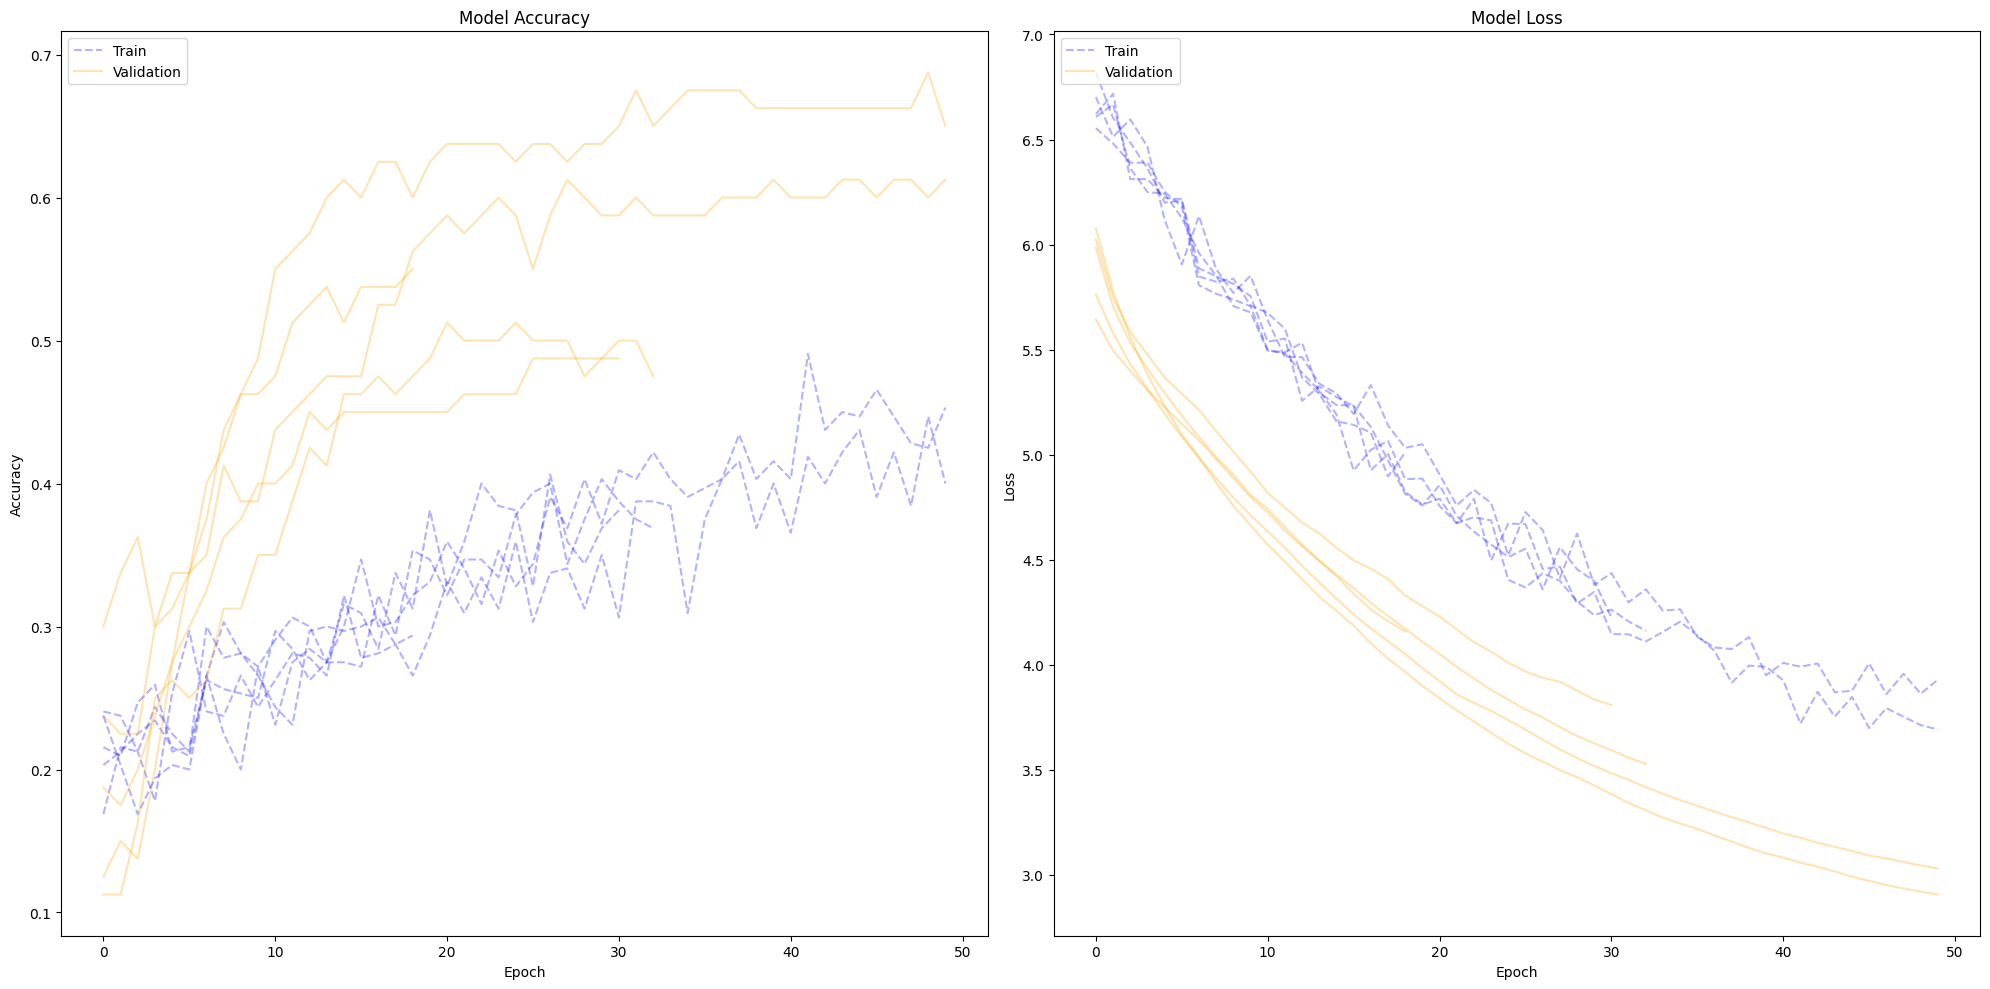

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step


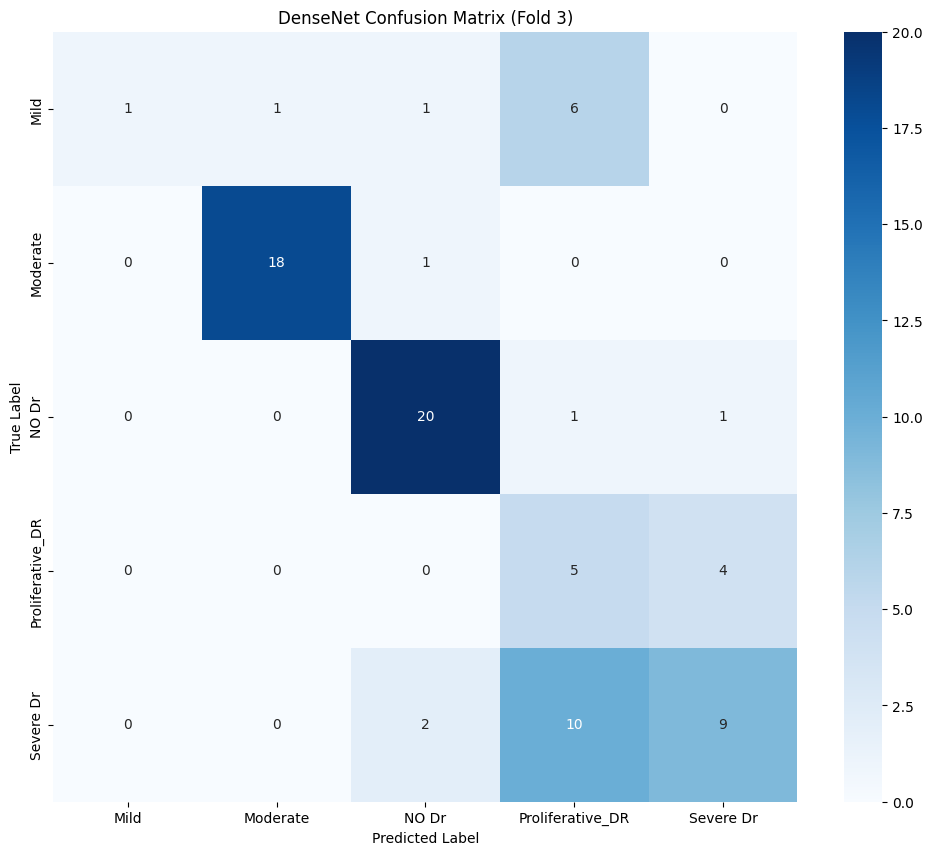


Making prediction on test image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


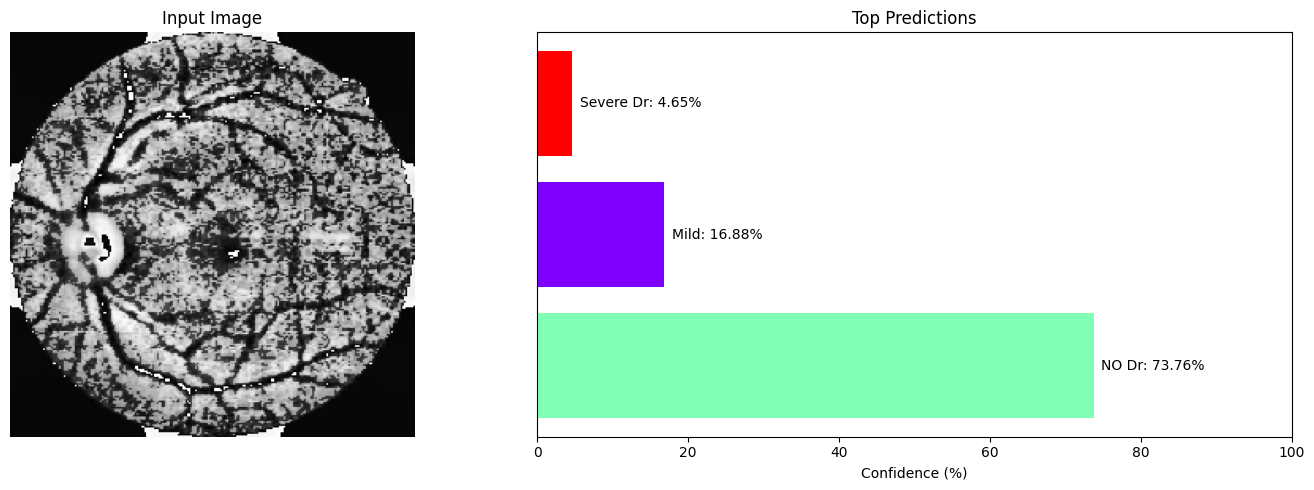


Prediction Probabilities:
NO Dr: 73.76%
Mild: 16.88%
Severe Dr: 4.65%
Moderate: 2.51%
Proliferative_DR: 2.21%


In [4]:

# ====== PREDICTION UTILITIES ======
class DenseNetPredictor:  # Changed class name
    def __init__(self, model_path, class_indices):
        self.model = tf.keras.models.load_model(model_path)
        self.class_indices = class_indices
        self.img_size = Config.IMG_SIZE
        
    def predict_image(self, image_path):
        """Make prediction with visualization."""
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
            
        img = image.load_img(image_path, target_size=self.img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        pred = self.model.predict(img_array)[0]
        sorted_idx = np.argsort(pred)[::-1]
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Input Image')
        
        plt.subplot(1, 2, 2)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.class_indices)))
        for i, idx in enumerate(sorted_idx[:3]):
            plt.barh(i, pred[idx]*100, color=colors[idx])
            plt.text(pred[idx]*100 + 1, i, 
                    f"{list(self.class_indices.keys())[idx]}: {pred[idx]*100:.2f}%",
                    va='center')
        plt.yticks([])
        plt.xlabel('Confidence (%)')
        plt.title('Top Predictions')
        plt.xlim(0, 100)
        plt.tight_layout()
        plt.show()
        
        return {list(self.class_indices.keys())[i]: float(pred[i]) for i in sorted_idx}

# ====== MAIN EXECUTION ======
if __name__ == "__main__":
    # Run training
    history_list, metrics, class_indices, X, y = run_training()
    
    # Visualize results
    plot_results(history_list, metrics, class_indices, X, y)
    
    # Example prediction
    predictor = DenseNetPredictor('densenet_fold_1.keras', class_indices)  # Changed to densenet
    test_image = os.path.join(Config.BASE_DIR, 'NO Dr/005b95c28852.png')
    
    if os.path.exists(test_image):
        print("\nMaking prediction on test image...")
        predictions = predictor.predict_image(test_image)
        print("\nPrediction Probabilities:")
        for cls, prob in predictions.items():
            print(f"{cls}: {prob*100:.2f}%")
    else:
        print(f"\nTest image not found at: {test_image}")
        print("Please provide a valid image path for prediction.")